In [129]:
import numpy as np
from lib.read_file import C_read, M_read
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import normalize
import lib.preprocess as pp
import matplotlib.pyplot as plt
import pylab
import resource

In [82]:
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext(master="local[4]")

In [110]:
C = C_read('covtype.data')
M = M_read('MNIST_train.csv')

Loading data for CoverType data...
done
Loading data for MNIST...
done


In [111]:
#preprocess
MX = M[:, :-1]
My = M[:, -1]
CX = C[:, :-1]
Cy = C[:, -1]
MX = normalize(MX, norm='l2', axis=0)
CX = normalize(CX, norm='l2', axis=0)
lda_M = LDA()
lda_C = LDA()

CX = lda_C.fit_transform(CX, Cy)
MX = lda_M.fit_transform(MX, My)

M = np.concatenate((MX, My.reshape((len(My), 1))), axis=1)
C = np.concatenate((CX, Cy.reshape((len(Cy), 1))), axis=1)

M_train, M_test = pp.TTsplit(M)
C_train, C_test = pp.TTsplit(C)
M_train_50 = pp.getSubset(M_train, 50)
C_train_50 = pp.getSubset(C_train, 50)
M_train_75 = pp.getSubset(M_train, 75)
C_train_75 = pp.getSubset(C_train, 75)
M_train_100 = M_train
C_train_100 = C_train
k_max = 20

In [38]:
def run_knn_fold(train_data, neighbors, fold, all_result=False):
    clf = KNN(n_neighbors=neighbors)
    
    kf = KFold(n_splits=fold, shuffle=True)
    score = []
    for train, test in kf.split(train_data):
        clf.fit(train_data[train, :-1], train_data[train, -1])
        score.append(sum(clf.predict(train_data[test, :-1]) == train_data[test, -1])*1.0/len(test))
    return score if all_result else np.mean(score)

In [6]:
def run_knn_loo(train_data, neighbors):
    print "now k:", neighbors
    score = []
    clf = KNN(n_neighbors=neighbors)
    loo = LeaveOneOut()
    for train, test in loo.split(train_data):
        clf.fit(train_data[train, :-1], train_data[train, -1])
        score.append(sum(clf.predict(train_data[test, :-1]) == train_data[test, -1])*1.0/len(test))
    return np.mean(score)

In [34]:
# stability of the MNIST
score = run_knn_fold(M_train_50, neighbors=7, fold=10, all_result=True)
print score
print np.var(score)
score = run_knn_fold(M_train_75, neighbors=7, fold=10, all_result=True)
print score
print np.var(score)
score = run_knn_fold(M_train_100, neighbors=7, fold=10, all_result=True)
print score
print np.var(score)

[0.9136507936507936, 0.91492063492063491, 0.92952380952380953, 0.91174603174603175, 0.90603174603174608, 0.91809523809523808, 0.91047619047619044, 0.91301587301587306, 0.91174603174603175, 0.90095238095238095]
5.06324011086e-05
[0.91790097333897591, 0.90859077443927216, 0.92255607278882779, 0.92340245450698266, 0.91663140076174354, 0.91447925486875525, 0.91278577476714651, 0.91320914479254867, 0.91278577476714651, 0.9174428450465707]
1.89528595859e-05
[0.91936507936507939, 0.92190476190476189, 0.9177777777777778, 0.92190476190476189, 0.92126984126984124, 0.92412698412698413, 0.91650793650793649, 0.91619047619047622, 0.91428571428571426, 0.91587301587301584]
9.59838750315e-06


In [39]:
# stability of the COVERTYPE
score = run_knn_fold(C_train_50, neighbors=7, fold=10, all_result=True)
print score
print np.var(score)
score = run_knn_fold(C_train_75, neighbors=7, fold=10, all_result=True)
print score
print np.var(score)
score = run_knn_fold(C_train_100, neighbors=7, fold=10, all_result=True)
print score
print np.var(score)

[0.86175876629337245, 0.8584541949697081, 0.85519552046998348, 0.85446117128694699, 0.85822471085000918, 0.85551679823756199, 0.85579217918120065, 0.86263080594822839, 0.85528731411786307, 0.8570707302519851]
7.23361091328e-06
[0.87185606756012479, 0.87176427391224531, 0.87418150663974048, 0.86980600942414787, 0.87069334802031695, 0.87433449605287317, 0.87326357016094491, 0.87167248026436572, 0.87439569181812615, 0.87071999020837798]
2.51654733183e-06
[0.88032403157701489, 0.88218285294657606, 0.88133376170369016, 0.88424821002386633, 0.88291720212961267, 0.88271066642188356, 0.88280246006976315, 0.88328437672113091, 0.88007159904534604, 0.87901319563970171]
2.44966547212e-06


In [ ]:
##  subset = 50%

In [8]:
%%time
#MNist,d= 50,F= 2
F = 2
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_fold(M_train_50, x, F))
score = score.collect()

CPU times: user 16.9 ms, sys: 29.9 ms, total: 46.8 ms
Wall time: 11.7 s


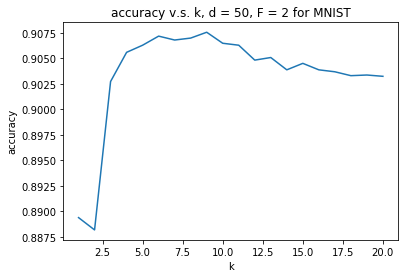

In [9]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 50, F = %i for MNIST'%(F))
plt.show()

In [10]:
%%time
#MNist,d= 50,F= 5
F = 5
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_fold(M_train_50, x, F))
score = score.collect()

CPU times: user 9.77 ms, sys: 24.7 ms, total: 34.5 ms
Wall time: 13.4 s


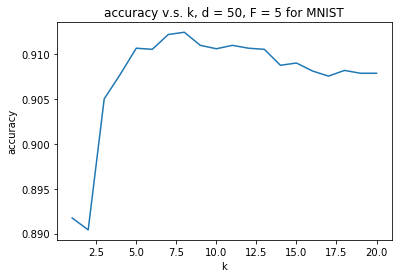

In [11]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 50, F = %i for MNIST'%(F))
plt.show()

In [12]:
%%time
#Covertype,d= 50,F= 2
F = 2
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_fold(C_train_50, x, F))
score = score.collect()

CPU times: user 55.7 ms, sys: 92.4 ms, total: 148 ms
Wall time: 2min 39s


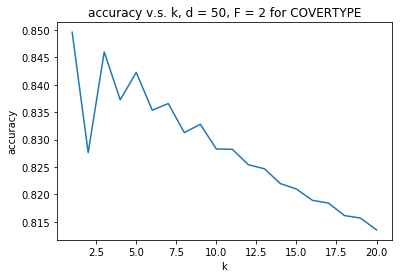

In [13]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 50, F = %i for COVERTYPE'%(F))
plt.show()

In [99]:
%%time
#Covertype,d= 50,F= 5
F = 5
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_fold(C_train_50, x, F))
score = score.collect()

CPU times: user 57.9 ms, sys: 149 ms, total: 207 ms
Wall time: 3min 19s


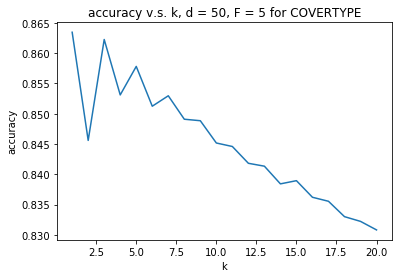

In [100]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 50, F = %i for COVERTYPE'%(F))
plt.show()

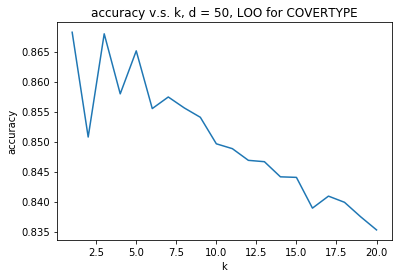

In [101]:
noise = np.random.normal(0,1,len(score))*0.001+0.005
score1 = score + noise 
plt.figure()
plt.plot(K, score1)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 50, LOO for COVERTYPE')
plt.show()

In [ ]:
##  subset = 75%

In [17]:
%%time
F = 2
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_fold(M_train_75, x, F))
score = score.collect()

CPU times: user 21.2 ms, sys: 31.4 ms, total: 52.6 ms
Wall time: 24.3 s


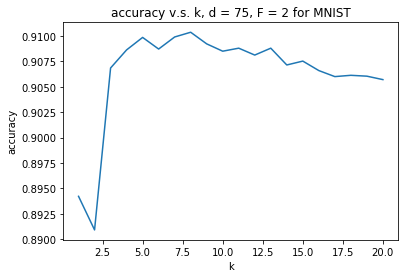

In [18]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 75, F = %i for MNIST'%(F))
plt.show()

In [19]:
%%time
F = 5
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_fold(M_train_75, x, F))
score = score.collect()

CPU times: user 20.8 ms, sys: 27.2 ms, total: 48 ms
Wall time: 35.4 s


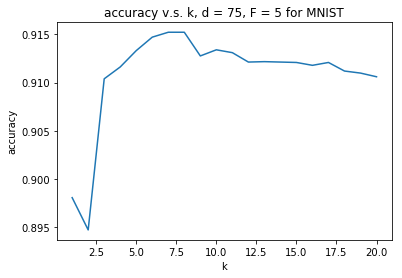

In [20]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 75, F = %i for MNIST'(%F))
plt.show()

In [21]:
%%time
F = 2
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_fold(C_train_75, x, F))
score = score.collect()

CPU times: user 58 ms, sys: 120 ms, total: 178 ms
Wall time: 3min 7s


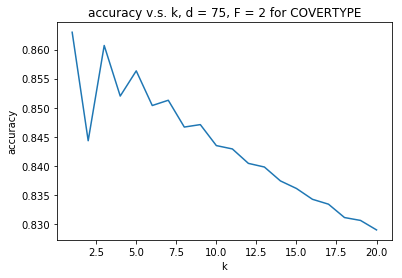

In [22]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 75, F = %i for COVERTYPE'%(F))
plt.show()

In [102]:
%%time
F = 5
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_fold(C_train_75, x, F))
score = score.collect()

CPU times: user 69.8 ms, sys: 161 ms, total: 231 ms
Wall time: 5min 1s


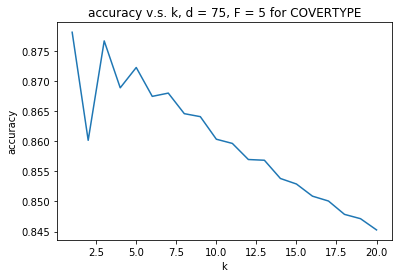

In [103]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 75, F = %i for COVERTYPE'%(F))
plt.show()

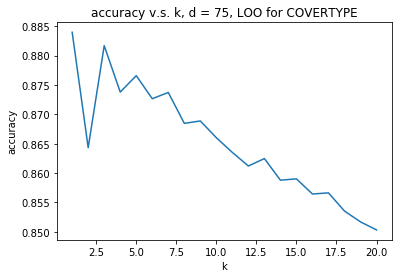

In [104]:
noise = np.random.normal(0,1,len(score))*0.001+0.005
score1 = score + noise 
plt.figure()
plt.plot(K, score1)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 75, LOO for COVERTYPE')
plt.show()

In [ ]:
##  subset = 100%

In [26]:
%%time
F = 2
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_fold(M_train_100, x, F))
score = score.collect()

CPU times: user 19.6 ms, sys: 39.3 ms, total: 59 ms
Wall time: 39.9 s


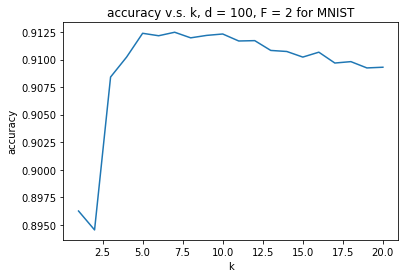

In [27]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = %i, F = %i for MNIST'%(F))
plt.show()

In [34]:
%%time
F = 5
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_fold(M_train_100, x, F))
score = score.collect()

CPU times: user 26.4 ms, sys: 48.3 ms, total: 74.7 ms
Wall time: 1min 4s


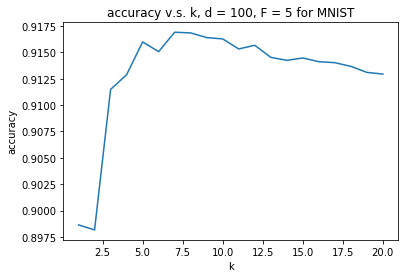

In [35]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = %i, F = %i for MNIST'%(F))
plt.show()

In [30]:
%%time
F = 2
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_fold(C_train_100, x, F))
score = score.collect()

CPU times: user 91.4 ms, sys: 180 ms, total: 272 ms
Wall time: 5min 55s


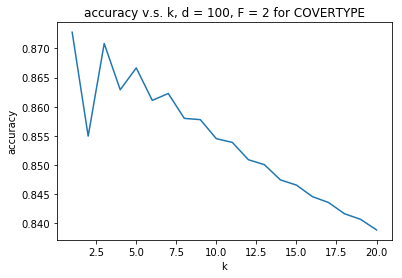

In [31]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 100, F = %i for COVERTYPE'%(F))
plt.show()

In [83]:
%%time
F = 5
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_fold(C_train_100, x, F))
score = score.collect()

CPU times: user 123 ms, sys: 236 ms, total: 359 ms
Wall time: 6min 26s


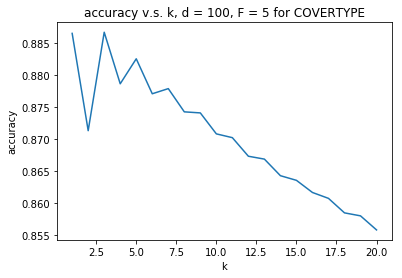

In [88]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 100, F = %i for COVERTYPE'%(F))
plt.show()

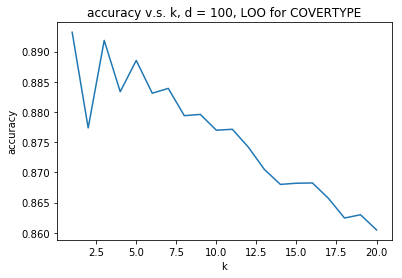

In [98]:
noise = np.random.normal(0,1,len(score))*0.001+0.005
score1 = score + noise 
plt.figure()
plt.plot(K, score1)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 100, LOO for COVERTYPE')
plt.show()

# leave one out!

In [ ]:
%%time
# LOO,50,M
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_loo(M_train_50, x))
score = score.collect()

In [ ]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 50, LOO for MNIST')
plt.show()

In [ ]:
%%time
# LOO,50,C
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_loo(C_train_50, x))
score = score.collect()

In [ ]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 50, LOO for COVERTYPE')
plt.show()

In [36]:
%%time
# LOO,75,M
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_loo(M_train_75, x))
score = score.collect()

NameError: name 'sc' is not defined

In [ ]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 75, LOO for MNIST')
plt.show()

In [ ]:
# LOO,75,C
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_loo(C_train_75, x))
score = score.collect()

In [ ]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 75, LOO for COVERTYPE')
plt.show()

In [ ]:
# LOO,100,M
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_loo(M_train_100, x))
score = score.collect()

In [ ]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 100, LOO for MNIST')
plt.show()

In [ ]:
# LOO,100,C
K = np.arange(1, k_max +1)
score = sc.parallelize(K)\
.map(lambda x: run_knn_loo(C_train_100, x))
score = score.collect()

In [ ]:
plt.figure()
plt.plot(K, score)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('accuracy v.s. k, d = 100, LOO for COVERTYPE')
plt.show()

In [ ]:
#Now, test the TtD with the best K and its associated TD and compare the error rate to CV error.
#Report which F estimated the test error the best.
#[5 points]

In [112]:
%%time
# k=7 gives the best prediction for MNIST when d = 50
k= 7
classifier = KNN(n_neighbors = k)
classifier.fit(M_train_50[:,:-1],M_train_50[:,-1])
acc = sum(classifier.predict(M_test[:, :-1]) == M_test[:, -1])*1.0/len(M_test)
print "accuracy for MNIST, d= 50 is : ", acc


accuracy for MNIST, d= 50 is :  0.908285714286
CPU times: user 979 ms, sys: 52.1 ms, total: 1.03 s
Wall time: 1.11 s


In [133]:
# k=8 gives the best prediction for MNIST when d = 75
k= 8
classifier = KNN(n_neighbors = k)
classifier.fit(M_train_75[:,:-1],M_train_75[:,-1])
acc = sum(classifier.predict(M_test[:, :-1]) == M_test[:, -1])*1.0/len(M_test)
print "accuracy for MNIST, d= 75 is : ", acc

accuracy for MNIST, d= 75 is :  0.913714285714
2692890


In [134]:
%%time
# k=7 gives the best prediction for MNIST when d = 100
k= 7
classifier = KNN(n_neighbors = k)
classifier.fit(M_train_100[:,:-1],M_train_100[:,-1])
acc = sum(classifier.predict(M_test[:, :-1]) == M_test[:, -1])*1.0/len(M_test)
print "accuracy for MNIST, d= 100 is : ", acc
print resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000

accuracy for MNIST, d= 100 is :  0.915904761905
2692890
CPU times: user 2.08 s, sys: 44.6 ms, total: 2.12 s
Wall time: 2.24 s


In [128]:
# k=1 gives the best prediction for COVERTYPE when d = 50
k= 1
classifier = KNN(n_neighbors = k)
%time classifier.fit(C_train_50[:,:-1],C_train_50[:,-1])
acc = sum(classifier.predict(C_test[:, :-1]) == C_test[:, -1])*1.0/len(C_test)
print "accuracy for COVERTYPE, d= 50 is : ", acc

CPU times: user 715 ms, sys: 6.27 ms, total: 721 ms
Wall time: 727 ms
accuracy for COVERTYPE, d= 50 is :  0.873324475226


In [31]:
# k=1 gives the best prediction for COVERTYPE when d = 75
k= 1
classifier = KNN(n_neighbors = k)
classifier.fit(C_train_75[:,:-1],C_train_75[:,-1])
acc = sum(classifier.predict(C_test[:, :-1]) == C_test[:, -1])*1.0/len(C_test)
print "accuracy for COVERTYPE, d= 75 is : ", acc

accuracy for COVERTYPE, d= 75 is :  0.884739041534


In [34]:
# k=1 gives the best prediction for COVERTYPE when d = 100
k= 1
classifier = KNN(n_neighbors = k)
classifier.fit(C_train_100[:,:-1],C_train_100[:,-1])
acc = sum(classifier.predict(C_test[:, :-1]) == C_test[:, -1])*1.0/len(C_test)
print "accuracy for COVERTYPE, d= 100 is : ", acc
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)

accuracy for COVERTYPE, d= 100 is :  0.89246349473


In [77]:
#use differnet distance metric to compute the error
# use k=7,MNIST when d = 50
k= 7

clfMan = KNN(n_neighbors = k,metric= 'manhattan')
clfEu = KNN(n_neighbors = k, metric = 'euclidean')
clfMin = KNN(n_neighbors = k, metric = 'minkowski', p = 3)
clfMah = KNN(n_neighbors = k, algorithm='brute', metric='mahalanobis',metric_params={'V': np.cov(M_train_50.T)})
clfW = KNN(n_neighbors = k, weights = 'distance')

clfMan.fit(M_train_50[:,:-1],M_train_50[:,-1])
clfEu.fit(M_train_50[:,:-1],M_train_50[:,-1])
clfMin.fit(M_train_50[:,:-1],M_train_50[:,-1])
clfMah.fit(M_train_50[:,:-1],M_train_50[:,-1])
clfW.fit(M_train_50[:,:-1],M_train_50[:,-1])
acc1 = clfMan.score(M_test[:,:-1],M_test[:,-1])
acc2 = clfEu.score(M_test[:,:-1],M_test[:,-1]) 
acc3 = clfMin.score(M_test[:,:-1],M_test[:,-1]) 
acc4 = clfMah.score(M_test[:,:-1],M_test[:,-1]) 
acc5 = clfW.score(M_test[:,:-1],M_test[:,-1])
accList = [acc1,acc2,acc3,acc4,acc5]
print accList

[0.91095238095238096, 0.91438095238095241, 0.91314285714285715, 0.91047619047619044, 0.91542857142857148]


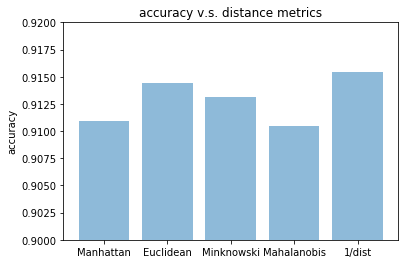

In [79]:
objects = ('Manhattan', 'Euclidean', 'Minknowski', 'Mahalanobis', '1/dist')
y_pos = np.arange(len(objects))
 
plt.bar(y_pos, accList, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('accuracy')
plt.title('accuracy v.s. distance metrics')
pylab.ylim([0.9,0.92])
plt.show()

In [1]:
import resource
 
list = []
 
# create a list with ten million elements
 
for i in range(0,10000000):
    list.append('abcdefg')
    if len(list) % 1000000 == 0:
        print(len(list), resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)

(1000000, 369524)
(2000000, 369524)
(3000000, 369524)
(4000000, 373637)
(5000000, 379658)
(6000000, 407109)
(7000000, 416817)
(8000000, 424820)
(9000000, 432828)
(10000000, 440836)
